In [40]:
import urx
import time, pickle
import numpy as np
import math3d as m3d

In [82]:
robot = urx.Robot("10.42.0.16", use_rt=True)

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 69
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1093
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


In [10]:
robot.set_digital_out(0, 1)
time.sleep(1)
robot.set_digital_out(0, 0)

In [16]:
robot.set_tcp((0, 0, 0.5, 0, 0, 0)) #ckeck Installation tab

In [14]:
robot.translate((0, 0, -0.05), acc=0.05, vel=0.05) #acceleration, velocity

<Transform:
<Orientation: 
array([[-0.09891123,  0.83688643, -0.53836575],
       [-0.4089152 , -0.52741222, -0.7447313 ],
       [-0.90719619,  0.14648365,  0.39438258]])>
<Vector: (-0.11497, -0.37466, 0.27273)>
>

In [44]:
robot.translate_tool((0, 0, -0.03), acc=0.05, vel=0.05)

<Transform:
<Orientation: 
array([[-0.16890046,  0.84351886, -0.50985152],
       [-0.51851251, -0.51596101, -0.68185703],
       [-0.83822277,  0.14919842,  0.52452113]])>
<Vector: (-0.42497, -0.62617, 0.69468)>
>

In [17]:
robot.get_pose()

<Transform:
<Orientation: 
array([[-0.09903769,  0.83682725, -0.53843449],
       [-0.40897296, -0.52751299, -0.7446282 ],
       [-0.90715635,  0.14645889,  0.39448339]])>
<Vector: (-0.35730, -0.70976, 0.45021)>
>

In [50]:
robot.get_pos()

<Vector: (-0.36120, -0.21739, 0.73764)>

In [51]:
robot.getl()

[-0.36120579612287107,
 -0.21735303165463984,
 0.7376364001750049,
 0.04533037032833755,
 0.01790177367091024,
 -0.07310780230245217]

In [52]:
def save_current_pos(fname):
    p = robot.get_pos()
    np.savetxt(fname, p.array)
       

def move_to_pos(fname, *args, **kwargs):
    p = np.loadtxt(fname)
    robot.movel((*p, 0, 0, 0), *args, **kwargs)
    

In [53]:
save_current_pos("in")

In [28]:
save_current_pos("out")

In [55]:
move_to_pos("in")

In [60]:
robot.x += 0.01 #1 hour 10 minutes up to this point

In [59]:
p = robot.get_pos()

In [37]:
p.array

array([-0.44037436, -0.64668612,  0.71023683])

In [41]:
m3d.Vector(p.array)

<Vector: (-0.44037, -0.64669, 0.71024)>

In [93]:
import threading
from IPython.display import display
import ipywidgets as widgets
import time

fw = widgets.HTML(
    value='',
    placeholder='No data',
    description='Force:',
)

def observe_force(fw):
    while True:
        fw.value = "<br>".join(["{0:5} {1:7.3f}".format(*c) for c in 
                                zip("x y z rx ry rz".split(), robot.get_tcp_force())])

thread = threading.Thread(target=observe_force, args=(fw,))
display(fw)
thread.start()



Exception in thread Thread-17:
Traceback (most recent call last):
  File "/home/dima/apps/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/dima/apps/anaconda3/lib/python3.5/site-packages/urx/ursecmon.py", line 280, in run
    data = self._get_data()
  File "/home/dima/apps/anaconda3/lib/python3.5/site-packages/urx/ursecmon.py", line 327, in _get_data
    tmp = self._s_secondary.recv(1024)
socket.timeout: timed out



In [85]:
robot.get_tcp_force().__str__()

'[-8.08827697  0.45056171  3.53951352  0.65056199  4.44886816 -0.04827402]'

In [1]:
%matplotlib notebook

import cv2 #pip install opencv-python
import matplotlib.pyplot as plt
import signal, time
import numpy as np
#to check: cv2.getBuildInformation()
print (*filter(lambda s: "FFMPEG" in s, cv2.getBuildInformation().split("\n")))
#for opencv with ffmpeg in conda
#https://github.com/conda-forge/opencv-feedstock/
#pip uninstall opencv
#pip uninstall opencv-python
#conda unistall opencv
#conda install conda=4.0.11
#conda config --add channels conda-forge
#conda install opencv


    FFMPEG:                      YES


In [2]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [3]:
vc = cv2.VideoCapture(1) #0 for the first webcam, 1 for the second..

In [16]:
def imshow(frame):
    plt.figure()
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(rgb_frame)

def online_view():
    plt.ion()

    if vc.isOpened(): # try to get the first frame
        is_capturing, frame = vc.read()
        imshow(frame)   
    else:
        is_capturing = False

    signal.signal(signal.SIGINT, signal_handler)
    is_interrupted = False
    while is_capturing:
        is_capturing, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        webcam_preview.set_data(frame)
        plt.draw()

        try:    # Avoids a NotImplementedError caused by `plt.pause`
            plt.pause(0.05)
        except Exception:
            pass
        if is_interrupted:
            vc.release()
            break
    
def get_frame():
    timeout = time.time() + 1
    while time.time() < timeout:
        if vc.isOpened(): # try to get the first frame
            is_capturing, frame = vc.read()
        else:
            raise (Exception("Unable to capture"))
    return frame


#frame = get_frame()
#imshow(frame)

#online_view()

In [17]:
def display_color(color):
    import matplotlib.patches as patches

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.add_patch(
        patches.Rectangle(
            (0., 0.),   # (x,y)
            1,          # width
            1,          # height
            color=color
        )
    )

In [20]:
from scipy.stats import itemfreq
def get_dominant_color(frame, show_quantized=False):
    arr = np.float32(frame)
    pixels = arr.reshape((-1, 3))

    n_colors = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    
    #print (_, labels, centroids)

    palette = np.uint8(centroids)
    quantized = palette[labels.flatten()]
    quantized = quantized.reshape(frame.shape)
    
    if show_quantized: imshow(quantized)
    
    hist = itemfreq(labels)[:, -1]
    max_color = np.argmax(hist)

    dominant_color = palette[max_color]
    dominance = np.max(hist)/np.sum(hist)
    return dominant_color, dominance

#get_dominant_color(frame)

<IPython.core.display.Javascript object>


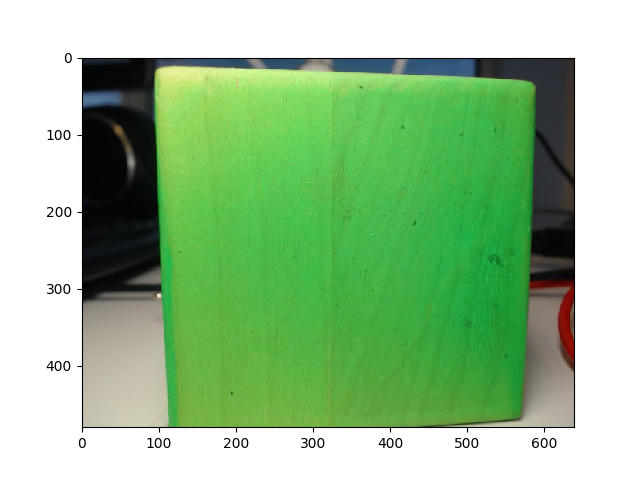

<IPython.core.display.Javascript object>


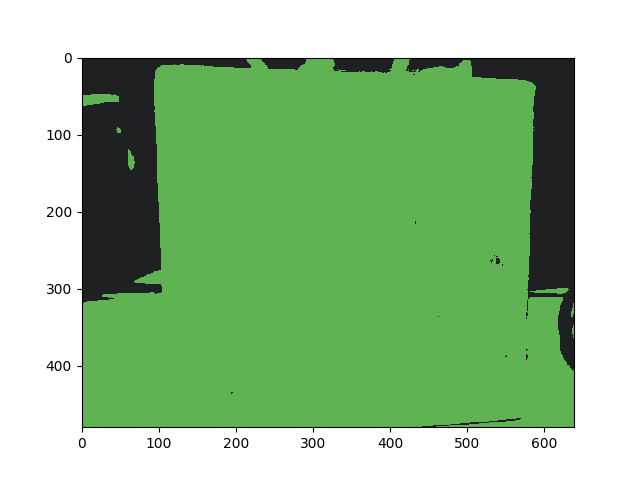

0.819104817708


<IPython.core.display.Javascript object>


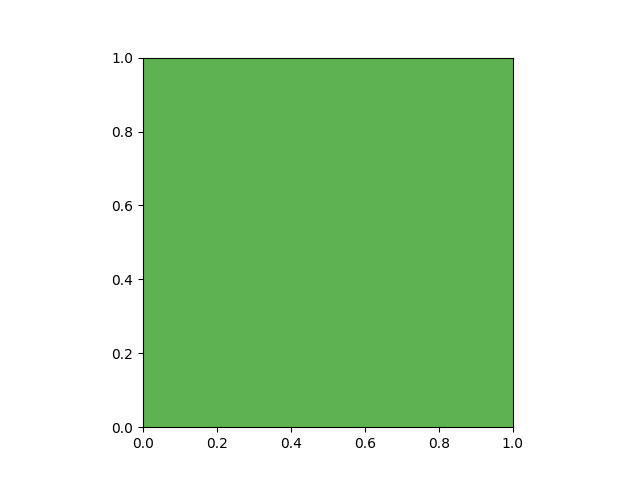

In [24]:
frame = get_frame()
imshow(frame)
dominant_color, dominance = get_dominant_color(frame, show_quantized=True)
print (dominance)
display_color(dominant_color[::-1]/256.)

In [64]:
dominant_color[::-1]

array([176,  20,   8], dtype=uint8)

In [29]:
dominant_colors = []
dominances = []
for i in range(20):
    dc, d = get_dominant_color(get_frame())
    dominant_colors.append(dc)
    dominances.append(d)
dominant_colors = np.vstack(dominant_colors)

In [30]:
dominant_colors

[array([115, 177, 141], dtype=uint8),
 array([115, 177, 141], dtype=uint8),
 array([115, 177, 141], dtype=uint8),
 array([115, 177, 141], dtype=uint8),
 array([115, 177, 141], dtype=uint8),
 array([115, 177, 141], dtype=uint8),
 array([115, 178, 141], dtype=uint8),
 array([115, 178, 141], dtype=uint8),
 array([115, 178, 141], dtype=uint8),
 array([115, 178, 142], dtype=uint8),
 array([115, 178, 142], dtype=uint8),
 array([115, 178, 142], dtype=uint8),
 array([115, 178, 142], dtype=uint8),
 array([115, 178, 142], dtype=uint8),
 array([116, 179, 142], dtype=uint8),
 array([116, 179, 142], dtype=uint8),
 array([116, 179, 142], dtype=uint8),
 array([116, 179, 142], dtype=uint8),
 array([116, 179, 142], dtype=uint8),
 array([116, 179, 142], dtype=uint8)]

In [28]:
dominances

[0.90990559895833334,
 0.91000000000000003,
 0.91009114583333328,
 0.91027994791666667,
 0.91007812499999996,
 0.9102734375,
 0.91028971354166666,
 0.91037434895833336,
 0.91042317708333331,
 0.91038736979166668,
 0.91041666666666665,
 0.91034830729166671,
 0.91046549479166672,
 0.91051432291666667,
 0.91052083333333333,
 0.910517578125,
 0.91064778645833333,
 0.91060546875000004,
 0.91070963541666672,
 0.91071614583333338]

In [35]:
(np.vstack(dominant_colors) - np.array((115, 177,141)))

AttributeError: 'numpy.ndarray' object has no attribute 'norm'